In [ ]:
import warnings 
warnings.filterwarnings('ignore')

# basic libraries
import os
import numpy as np
import pandas as pd
from collections import Counter
import time

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from joblib import dump, load

#visulaization modules
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AnomalyDetection

/content/drive/.shortcut-targets-by-id/1-1gOU6MOGg2BfyagchzaUgQABprHUedU/AnomalyDetection


In [ ]:
colNames = ['indegree','outdegree','in_btc','out_btc','total_btc','mean_in_btc','mean_out_btc','out_and_tx_malicious']
dTypes = {1:np.uint16,2:np.uint16,3:np.float32,4:np.float32,5:np.float32,6:np.float32,7:np.float32}
df = pd.read_csv("DG_out.csv",dtype=dTypes)
df = df.drop('tx_hash', axis=1)
df = df.drop('in_malicious', axis=1)
df = df.drop('out_malicious', axis=1)
df = df.drop('is_malicious', axis=1)
df = df.drop('all_malicious', axis=1)
df['out_and_tx_malicious'] = df['out_and_tx_malicious'].astype(np.uint8)
df.head()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,out_and_tx_malicious
0,0,1,0.0,50.0,50.0,0.0,50.0,0
1,1,2,50.0,50.0,100.0,50.0,25.0,0
2,1,1,10.0,10.0,20.0,10.0,10.0,0
3,1,1,40.0,30.0,70.0,40.0,30.0,0
4,1,2,30.0,30.0,60.0,30.0,15.0,0


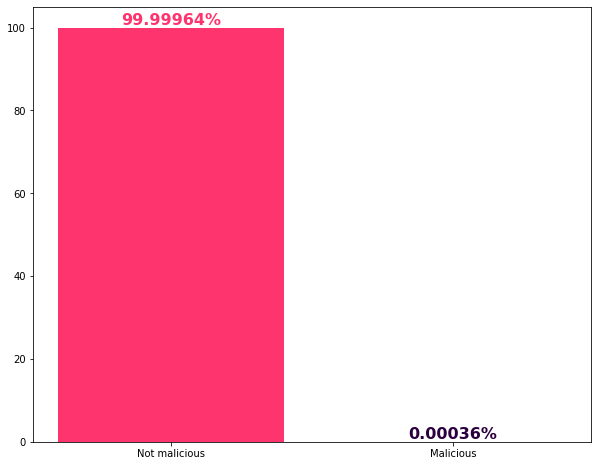

In [ ]:
label_counts = Counter(df['out_and_tx_malicious'])
names = ['Not malicious', 'Malicious']
values = [round(label_counts[0]/len(df)*100,5), round(label_counts[1]/len(df)*100,5)]
colors = ['#fe346e','#2c003e']

plt.figure(figsize=(10, 8))
bars = plt.bar(names, values,color=colors)
for i,rect in enumerate(bars):
  height = rect.get_height()
  plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{values[i]}%', {'weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':colors[i]}, ha='center', va='bottom')

plt.show()

# Dữ liệu chưa xử lí

In [ ]:
# Untransformed data statistics
round (df.drop('out_and_tx_malicious',axis=1).describe(), 2)

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc
count,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00
mean,2.15,2.15,51.59,51.55,103.09,46.72,27.12
std,7.42,4.51,1301.06,1299.25,2598.06,970.91,711.45
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,2.00,0.10,0.10,0.21,0.06,0.05
50%,1.00,2.00,0.93,0.96,1.96,0.54,0.49
75%,2.00,2.00,8.59,9.06,18.40,5.61,4.52
max,1932.00,1322.00,550000.00,500020.69,1050000.00,499259.59,500000.00


In [ ]:
pd.options.display.max_info_rows=35000000
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30248134 entries, 0 to 30248133
Data columns (total 8 columns):
 #   Column                Non-Null Count     Dtype  
---  ------                --------------     -----  
 0   indegree              30248134 non-null  uint16 
 1   outdegree             30248134 non-null  uint16 
 2   in_btc                30248134 non-null  float32
 3   out_btc               30248134 non-null  float32
 4   total_btc             30248134 non-null  float32
 5   mean_in_btc           30248134 non-null  float32
 6   mean_out_btc          30248134 non-null  float32
 7   out_and_tx_malicious  30248134 non-null  uint8  
dtypes: float32(5), uint16(2), uint8(1)
memory usage: 721.2 MB


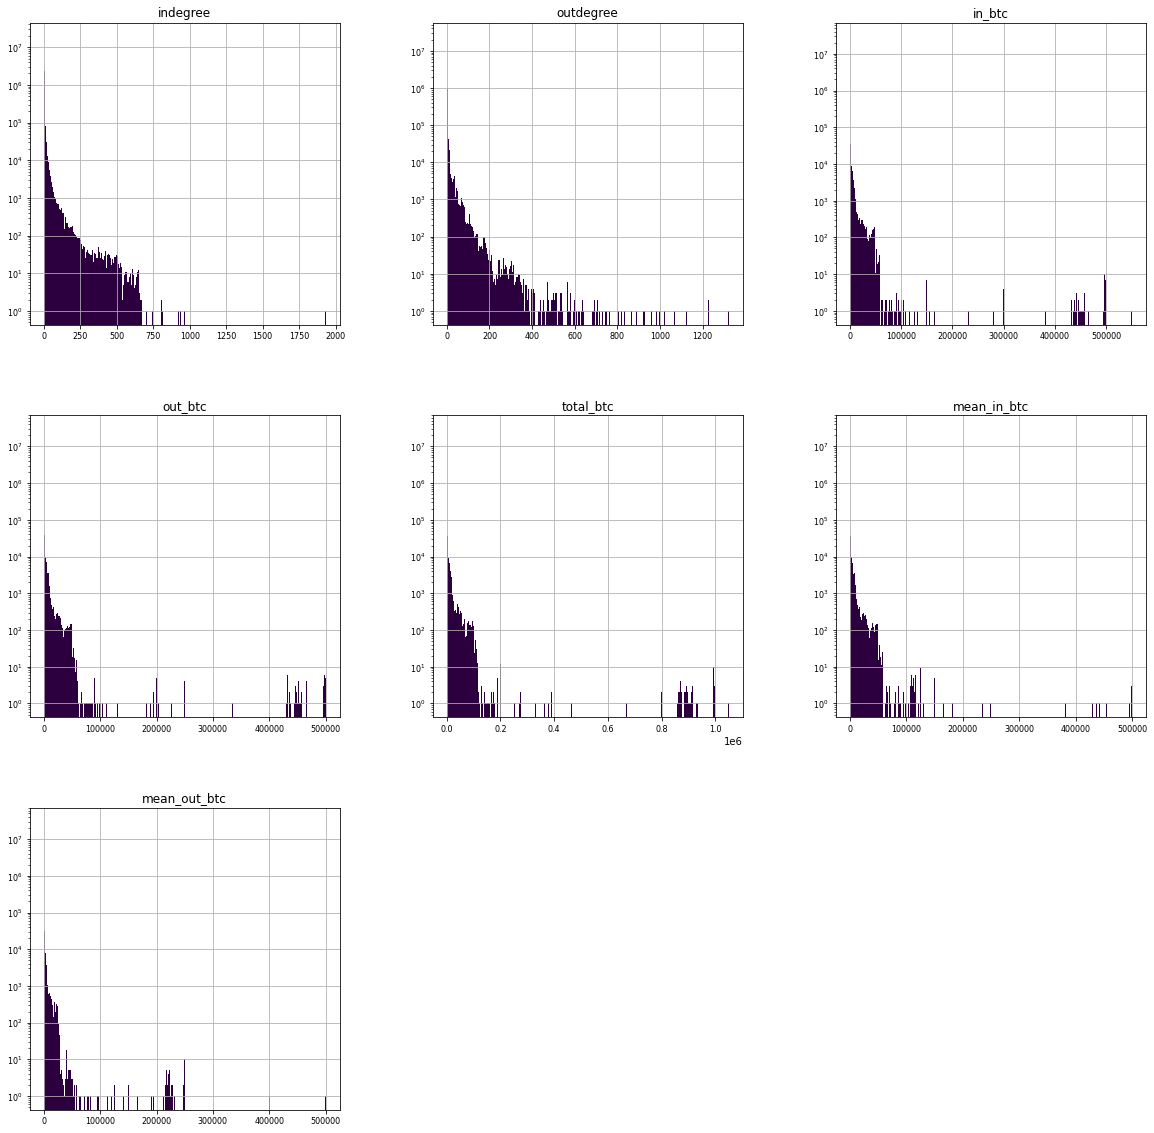

In [ ]:
# Untransformed data
df.drop('out_and_tx_malicious',axis=1).hist(figsize=(20, 20), bins=1000, xlabelsize=8, ylabelsize=8, log=True,color=colors[1]);
plt.savefig('Untransformed_data.png')

# Dữ liệu khi dùng log(x+1) transform

In [ ]:
# Log scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

In [ ]:
# transformed data statistics
round (scaled_df.drop('out_and_tx_malicious',axis=1).describe(), 2)


,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc
count,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00
mean,0.91,1.12,1.24,1.26,1.61,1.10,0.98
std,0.43,0.27,1.42,1.42,1.67,1.37,1.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.69,1.10,0.10,0.09,0.19,0.06,0.05
50%,0.69,1.10,0.66,0.67,1.09,0.43,0.40
75%,1.10,1.10,2.26,2.31,2.97,1.89,1.71
max,7.57,7.19,13.22,13.12,13.86,13.12,13.12


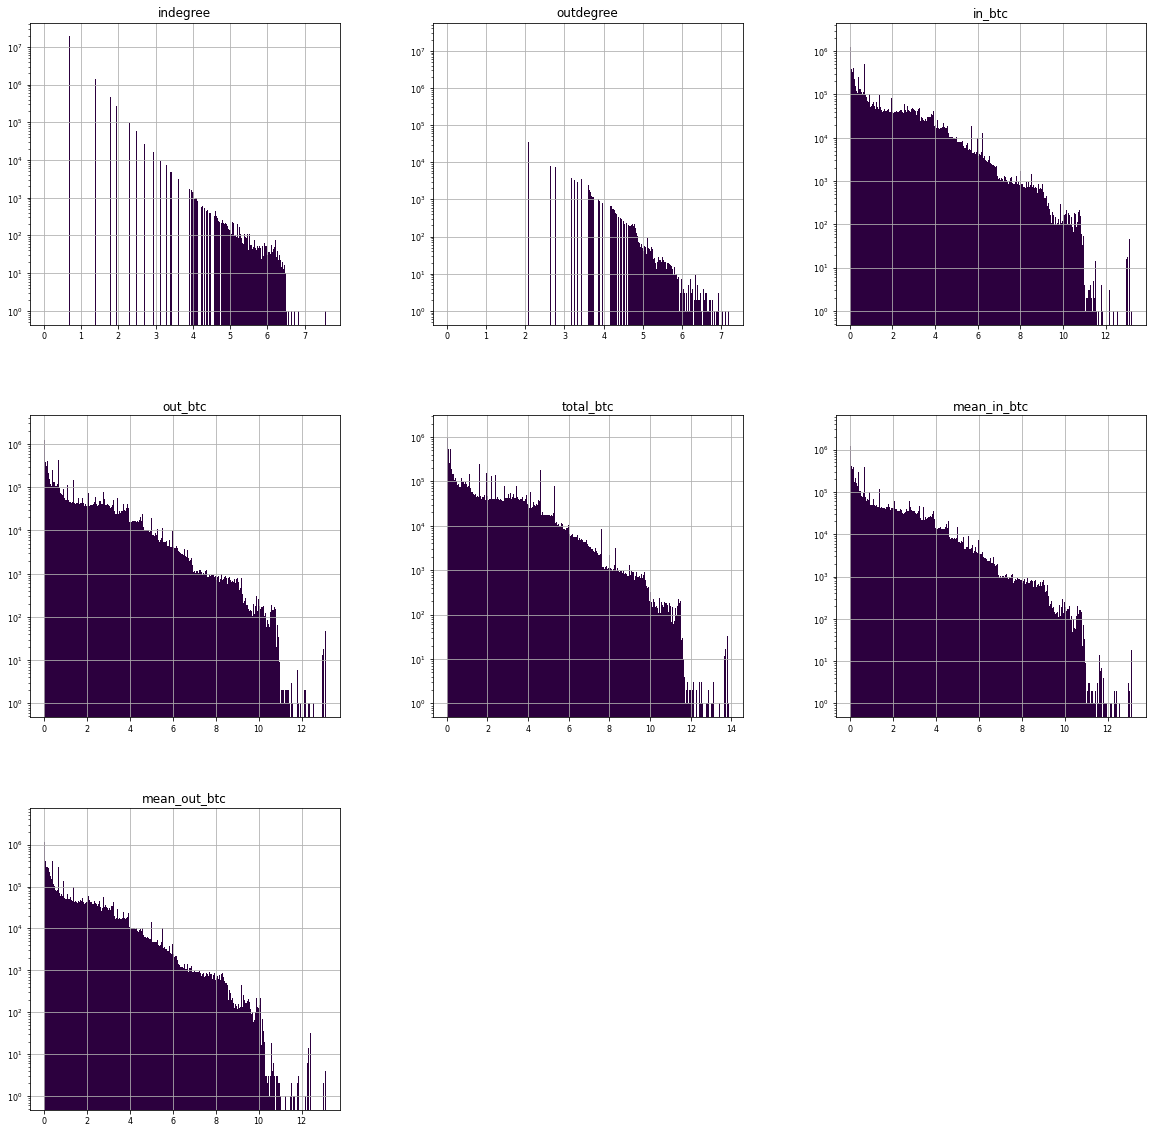

In [ ]:
# transformed data
scaled_df.drop('out_and_tx_malicious',axis=1).hist(figsize=(20, 20), bins=1000, xlabelsize=8, ylabelsize=8, log=True, color=colors[1]);
plt.savefig('Transformed_log_data.png')

# Dữ liệu khi dùng sqrt transform

In [ ]:
# sqrt scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.sqrt(scaled_df['indegree'])
scaled_df['outdegree']= np.sqrt(scaled_df['outdegree'])
scaled_df['in_btc'] = np.sqrt(scaled_df['in_btc'])
scaled_df['out_btc']= np.sqrt(scaled_df['out_btc'])
scaled_df['total_btc']= np.sqrt(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.sqrt(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.sqrt(scaled_df['mean_out_btc'])

In [ ]:
#transformed data statistics
round (scaled_df.drop('out_and_tx_malicious',axis=1).describe(), 2)


,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc
count,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00
mean,1.12,1.13,2.38,2.40,3.40,2.12,1.74
std,0.70,0.47,6.66,6.65,9.40,6.39,4.81
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,1.41,0.32,0.32,0.45,0.25,0.22
50%,1.00,1.41,0.97,0.98,1.40,0.73,0.70
75%,1.41,1.41,2.93,3.01,4.29,2.37,2.13
max,43.95,36.36,741.62,707.12,1024.70,706.58,707.11


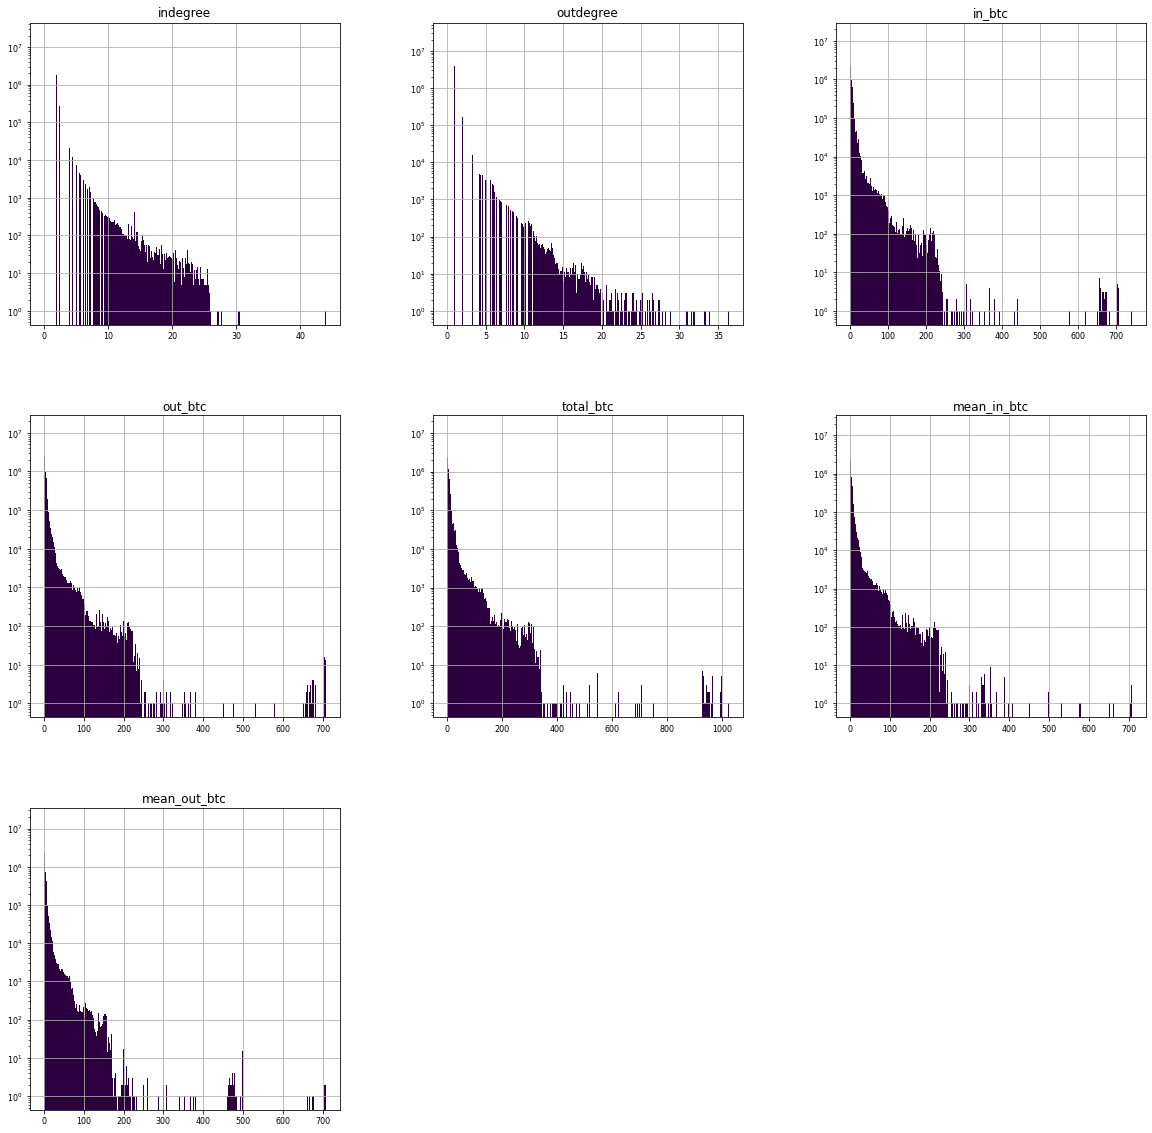

In [ ]:
# transformed data
scaled_df.drop('out_and_tx_malicious',axis=1).hist(figsize=(20, 20), bins=1000, xlabelsize=8, ylabelsize=8, log=True, color=colors[1]);
plt.savefig('Transformed_sqrt_data.png')

# log(x+1) và standardscaler

In [ ]:
# Log scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

from sklearn.preprocessing import StandardScaler
rob_scaler = StandardScaler()

scaled_df['indegree'] = rob_scaler.fit_transform(scaled_df['indegree'].values.reshape(-1,1))
scaled_df['outdegree'] = rob_scaler.fit_transform(scaled_df['outdegree'].values.reshape(-1,1))
scaled_df['in_btc'] = rob_scaler.fit_transform(scaled_df['in_btc'].values.reshape(-1,1))
scaled_df['out_btc'] = rob_scaler.fit_transform(scaled_df['out_btc'].values.reshape(-1,1))
scaled_df['total_btc'] = rob_scaler.fit_transform(scaled_df['total_btc'].values.reshape(-1,1))
scaled_df['mean_in_btc'] = rob_scaler.fit_transform(scaled_df['mean_in_btc'].values.reshape(-1,1))
scaled_df['mean_out_btc'] = rob_scaler.fit_transform(scaled_df['mean_out_btc'].values.reshape(-1,1))

In [ ]:
#transformed data statistics
round (scaled_df.drop('out_and_tx_malicious',axis=1).describe(), 2)


,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc
count,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00
mean,-0.01,0.01,0.01,0.01,-0.00,-0.00,-0.00
std,0.92,1.00,0.89,0.89,0.88,0.90,0.90
min,-2.04,-4.00,-0.85,-0.85,-0.96,-0.77,-0.76
25%,-0.54,0.10,-0.78,-0.79,-0.85,-0.73,-0.73
50%,-0.54,0.10,-0.43,-0.43,-0.36,-0.49,-0.47
75%,0.34,0.10,0.59,0.60,0.69,0.47,0.47
max,14.36,22.81,7.53,7.42,6.74,7.87,8.70


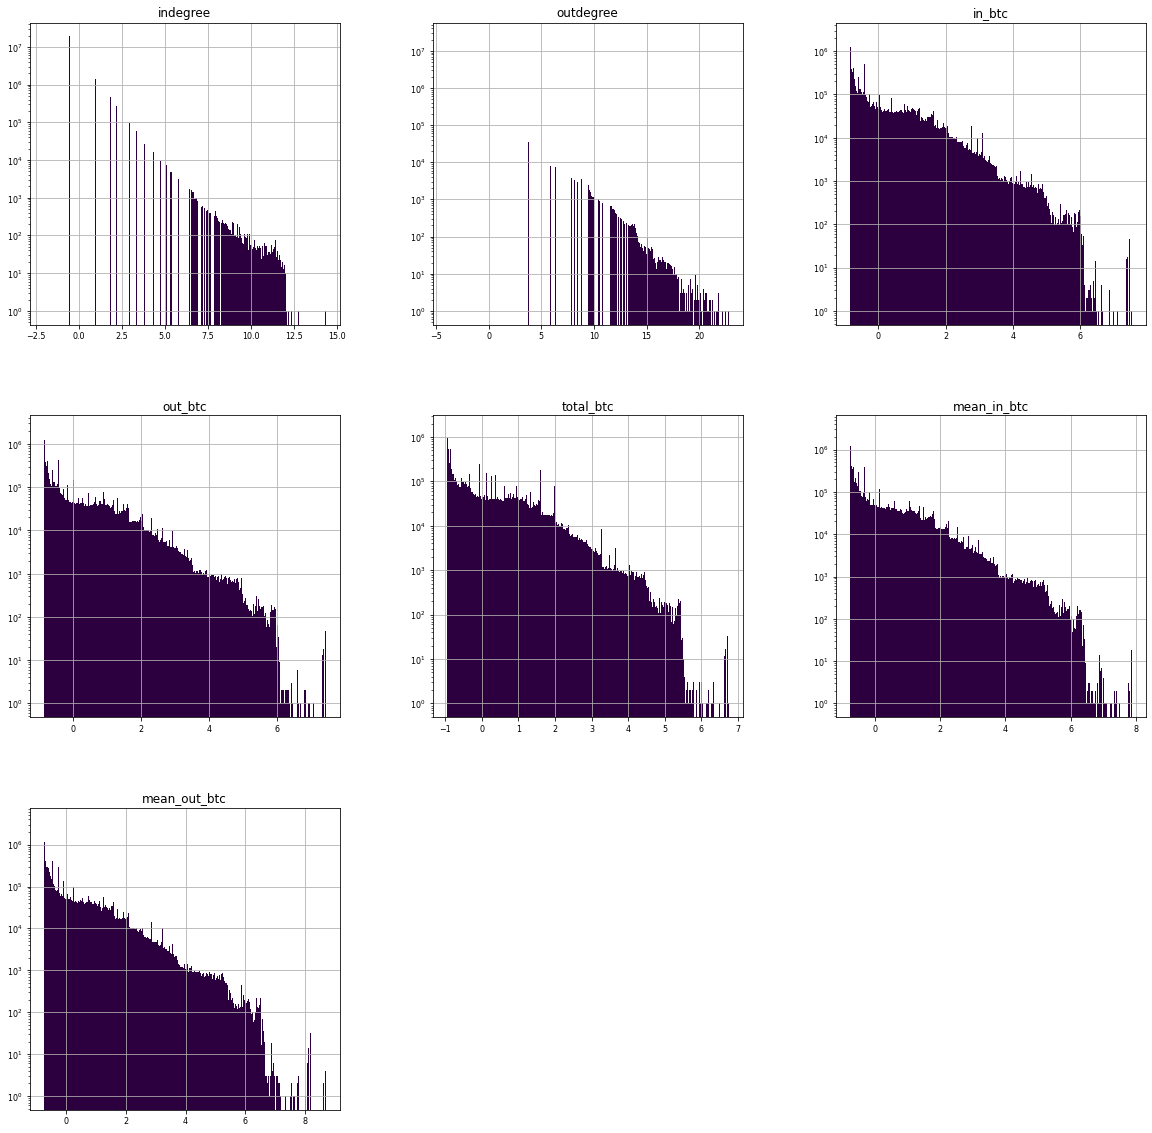

In [ ]:
# transformed data
scaled_df.drop('out_and_tx_malicious',axis=1).hist(figsize=(20, 20), bins=1000, xlabelsize=8, ylabelsize=8, log=True, color=colors[1]);
plt.savefig('Transformed_log_ss_data.png')

# log(x+1) và robustscaler

In [ ]:
# Log scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

scaled_df['indegree'] = rob_scaler.fit_transform(scaled_df['indegree'].values.reshape(-1,1))
scaled_df['outdegree'] = rob_scaler.fit_transform(scaled_df['outdegree'].values.reshape(-1,1))
scaled_df['in_btc'] = rob_scaler.fit_transform(scaled_df['in_btc'].values.reshape(-1,1))
scaled_df['out_btc'] = rob_scaler.fit_transform(scaled_df['out_btc'].values.reshape(-1,1))
scaled_df['total_btc'] = rob_scaler.fit_transform(scaled_df['total_btc'].values.reshape(-1,1))
scaled_df['mean_in_btc'] = rob_scaler.fit_transform(scaled_df['mean_in_btc'].values.reshape(-1,1))
scaled_df['mean_out_btc'] = rob_scaler.fit_transform(scaled_df['mean_out_btc'].values.reshape(-1,1))

In [ ]:
#transformed data statistics
round (scaled_df.drop('out_and_tx_malicious',axis=1).describe(), 2)


,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc
count,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00
mean,0.60,-0.03,0.30,0.29,0.20,0.47,0.46
std,1.05,0.27,0.65,0.64,0.59,0.71,0.72
min,-1.71,-1.10,-0.30,-0.30,-0.39,-0.23,-0.24
25%,0.00,0.00,-0.26,-0.26,-0.32,-0.20,-0.21
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,0.00,0.74,0.74,0.68,0.80,0.79
max,16.95,6.09,5.80,5.62,4.60,6.95,7.67


OSError: ignored

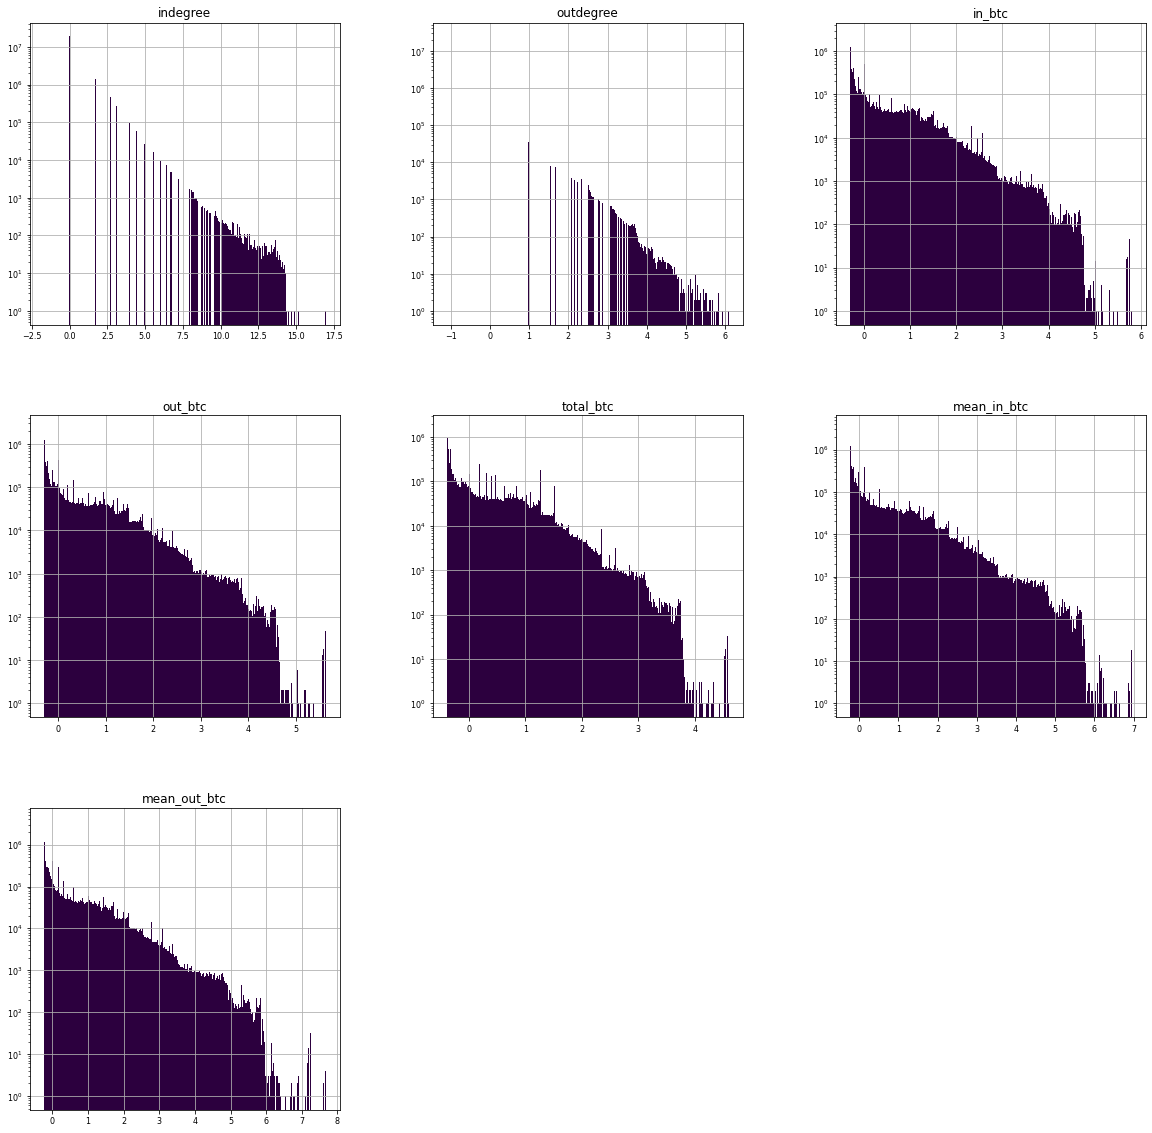

In [ ]:
# transformed data
scaled_df.drop('out_and_tx_malicious',axis=1).hist(figsize=(20, 20), bins=1000, xlabelsize=8, ylabelsize=8, log=True, color=colors[1]);
plt.savefig('Transformed_log_rn_data.png')

# Range cho các thuộc tính


In [ ]:
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

robust_scaled_data = scaled_df.copy()
standard_scaled_data = scaled_df.copy()

from sklearn.preprocessing import RobustScaler, StandardScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

robust_scaled_data['indegree'] = rob_scaler.fit_transform(robust_scaled_data['indegree'].values.reshape(-1,1))
robust_scaled_data['outdegree'] = rob_scaler.fit_transform(robust_scaled_data['outdegree'].values.reshape(-1,1))
robust_scaled_data['in_btc'] = rob_scaler.fit_transform(robust_scaled_data['in_btc'].values.reshape(-1,1))
robust_scaled_data['out_btc'] = rob_scaler.fit_transform(robust_scaled_data['out_btc'].values.reshape(-1,1))
robust_scaled_data['total_btc'] = rob_scaler.fit_transform(robust_scaled_data['total_btc'].values.reshape(-1,1))
robust_scaled_data['mean_in_btc'] = rob_scaler.fit_transform(robust_scaled_data['mean_in_btc'].values.reshape(-1,1))
robust_scaled_data['mean_out_btc'] = rob_scaler.fit_transform(robust_scaled_data['mean_out_btc'].values.reshape(-1,1))


standard_scaled_data['indegree'] = std_scaler.fit_transform(standard_scaled_data['indegree'].values.reshape(-1,1))
standard_scaled_data['outdegree'] = std_scaler.fit_transform(standard_scaled_data['outdegree'].values.reshape(-1,1))
standard_scaled_data['in_btc'] = std_scaler.fit_transform(standard_scaled_data['in_btc'].values.reshape(-1,1))
standard_scaled_data['out_btc'] = std_scaler.fit_transform(standard_scaled_data['out_btc'].values.reshape(-1,1))
standard_scaled_data['total_btc'] = std_scaler.fit_transform(standard_scaled_data['total_btc'].values.reshape(-1,1))
standard_scaled_data['mean_in_btc'] = std_scaler.fit_transform(standard_scaled_data['mean_in_btc'].values.reshape(-1,1))
standard_scaled_data['mean_out_btc'] = std_scaler.fit_transform(standard_scaled_data['mean_out_btc'].values.reshape(-1,1))
# standard_scaled_data = standard_scaler.fit_transform(scaled_df)
# robust_scaled_data = robust_scaled_data.fit_transform(scaled_df)
# dataframe with both standard and robust scaled values

result_robust_scaled_data = round (robust_scaled_data.drop('out_and_tx_malicious',axis=1).describe(), 2)
result_standard_scaled_data = round (standard_scaled_data.drop('out_and_tx_malicious',axis=1).describe(), 2) 
columns = result_robust_scaled_data.columns
range_robust_scaled_data = []
range_standard_scaled_data = []
for i in columns:
    range_robust_scaled_data.append(result_robust_scaled_data[i]['max'] - result_robust_scaled_data[i]['min'])
    range_standard_scaled_data.append(result_standard_scaled_data[i]['max'] - result_standard_scaled_data[i]['min'])

result_standard_scaled_data.loc['range'] = range_standard_scaled_data
result_robust_scaled_data.loc['range'] = range_robust_scaled_data


In [ ]:
scaled_df.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,out_and_tx_malicious
count,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07
mean,9.068233e-01,1.115117e+00,1.241015e+00,1.258480e+00,1.608031e+00,1.104540e+00,9.827655e-01,3.570468e-06
std,4.267719e-01,2.684758e-01,1.416047e+00,1.417364e+00,1.665402e+00,1.371146e+00,1.231181e+00,1.889565e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.931472e-01,1.098612e+00,9.531018e-02,9.485553e-02,1.872029e-01,6.203539e-02,4.903562e-02,0.000000e+00
50%,6.931472e-01,1.098612e+00,6.588145e-01,6.724342e-01,1.086796e+00,4.285474e-01,3.987761e-01,0.000000e+00
75%,1.098612e+00,1.098612e+00,2.260920e+00,2.308931e+00,2.965273e+00,1.889232e+00,1.708284e+00,0.000000e+00
max,7.566828e+00,7.187657e+00,1.321768e+01,1.312241e+01,1.386430e+01,1.312088e+01,1.312236e+01,1.000000e+00


In [ ]:
print("standard_scaled_data")
result_standard_scaled_data

standard_scaled_data


,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc
count,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00
mean,-0.01,0.01,0.01,0.01,-0.00,-0.00,-0.00
std,0.92,1.00,0.89,0.89,0.88,0.90,0.90
min,-2.04,-4.00,-0.85,-0.85,-0.96,-0.77,-0.76
25%,-0.54,0.10,-0.78,-0.79,-0.85,-0.73,-0.73
50%,-0.54,0.10,-0.43,-0.43,-0.36,-0.49,-0.47
75%,0.34,0.10,0.59,0.60,0.69,0.47,0.47
max,14.36,22.81,7.53,7.42,6.74,7.87,8.70
range,16.40,26.81,8.38,8.27,7.70,8.64,9.46


In [ ]:
print("robust_scaled_data")
result_robust_scaled_data

robust_scaled_data


,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc
count,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00,30248134.00
mean,0.60,-0.03,0.30,0.29,0.20,0.47,0.46
std,1.05,0.27,0.65,0.64,0.59,0.71,0.72
min,-1.71,-1.10,-0.30,-0.30,-0.39,-0.23,-0.24
25%,0.00,0.00,-0.26,-0.26,-0.32,-0.20,-0.21
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,0.00,0.74,0.74,0.68,0.80,0.79
max,16.95,6.09,5.80,5.62,4.60,6.95,7.67
range,18.66,7.19,6.10,5.92,4.99,7.18,7.91


# Plot hiệu suất các mô hình

In [ ]:
colNames = ['indegree','outdegree','in_btc','out_btc','total_btc','mean_in_btc','mean_out_btc','out_and_tx_malicious']
dTypes = {1:np.uint16,2:np.uint16,3:np.float32,4:np.float32,5:np.float32,6:np.float32,7:np.float32}
df = pd.read_csv("DG_out.csv",dtype=dTypes)
df = df.drop('tx_hash', axis=1)
df = df.drop('in_malicious', axis=1)
df = df.drop('out_malicious', axis=1)
df = df.drop('is_malicious', axis=1)
df = df.drop('all_malicious', axis=1)
df['out_and_tx_malicious'] = df['out_and_tx_malicious'].astype(np.uint8)
X = df.drop('out_and_tx_malicious',axis=1).to_numpy()
y = df['out_and_tx_malicious'].to_numpy()
del df

In [ ]:
def get_scaled_fold(fold_num):
  skf = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)
  i=0
  for train_index, test_index in skf.split(X,y):
    if i!=fold_num:
      i+=1
      continue
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # print('Train:',Counter(y_train))
    # print('Test:',Counter(y_test))

    for i in range(len(X_train[0,:])):
      X_train[:,i] = np.log1p(X_train[:,i])
      X_test[:,i] = np.log1p(X_test[:,i])

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train,y_train,X_test,y_test

  

[[30247940       86]
 [     108        0]]
[[30248026        0]
 [     108        0]]
[[30248026        0]
 [     108        0]]
[[30189278    58748]
 [     108        0]]
[[22751152  7496874]
 [      24       84]]
[[22239657  8008369]
 [      51       57]]
[[26066379  4181647]
 [      39       69]]
[[20956929  9291097]
 [      31       77]]


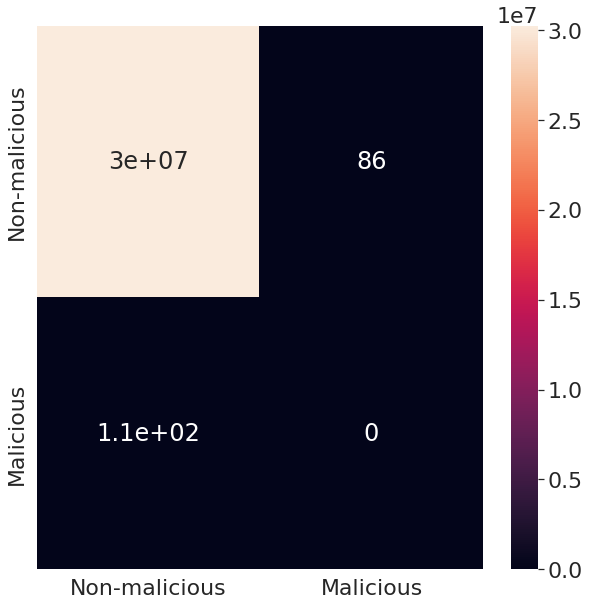

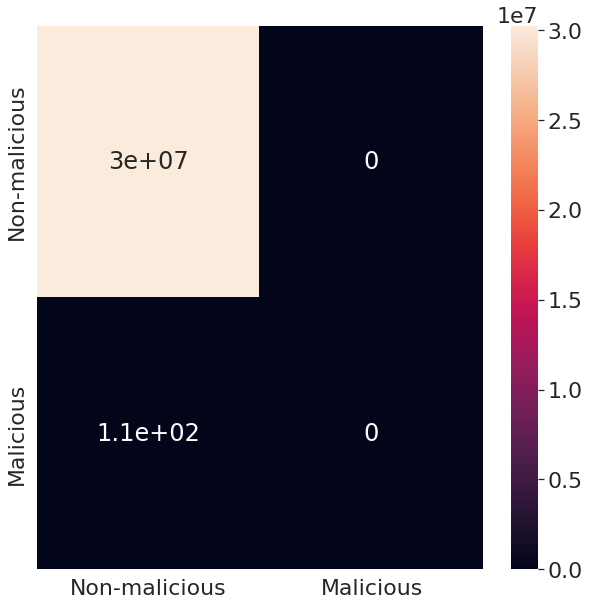

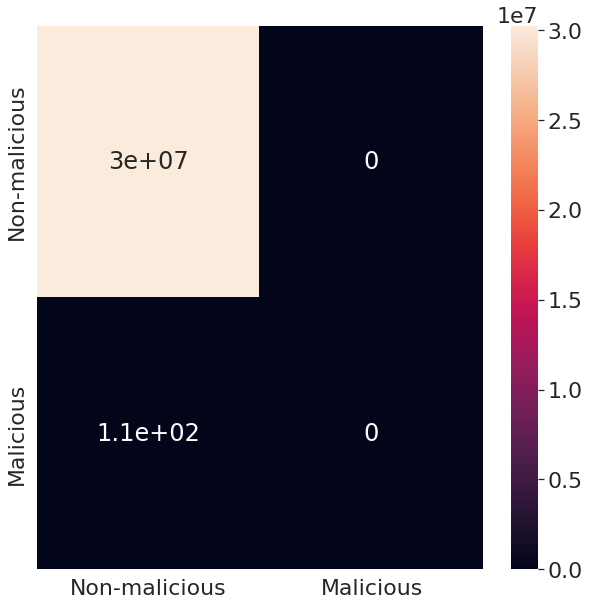

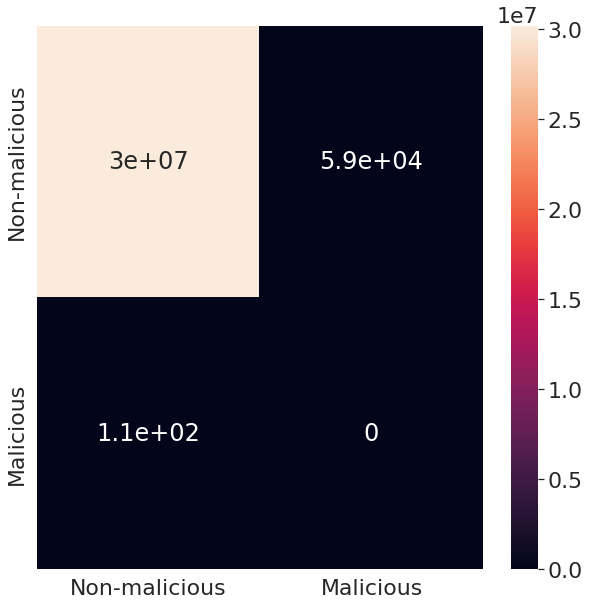

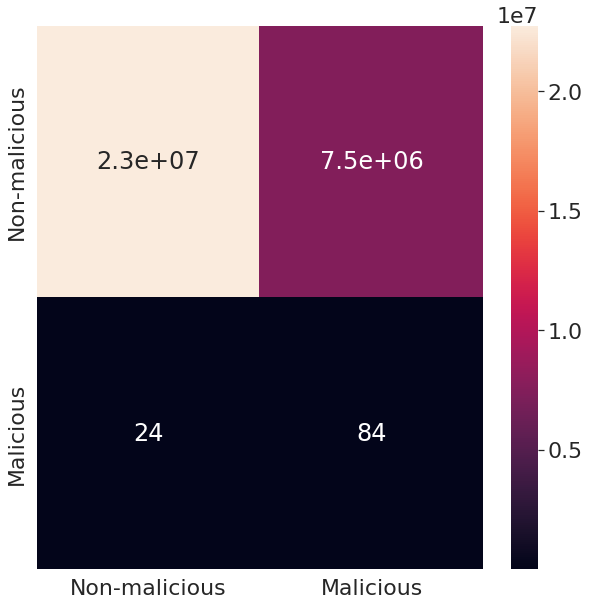

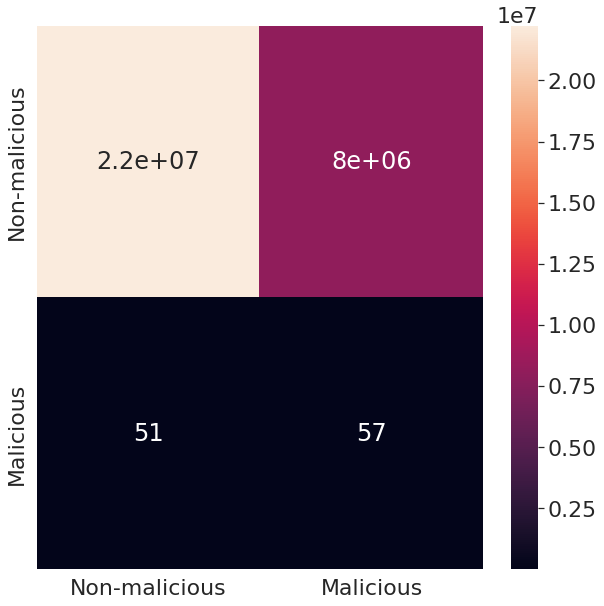

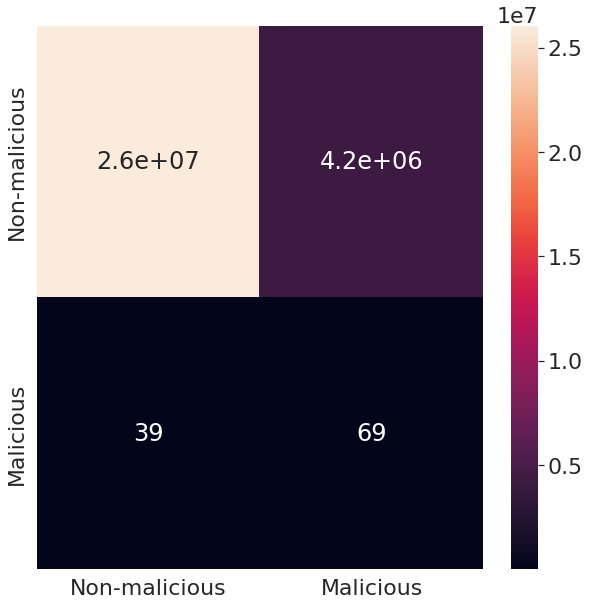

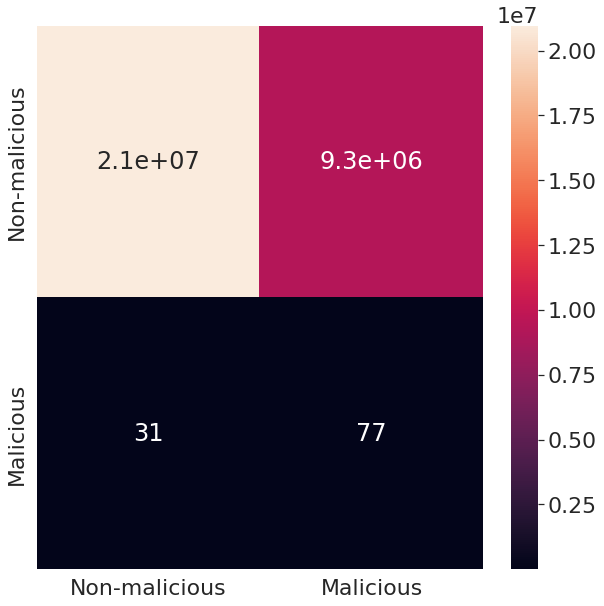

In [ ]:
models = ['DecisionTreeClassifier_original','SGDClassifier_original','MLPClassifier_original','DecisionTreeClassifier_cost_sensitive_learning',
          'SGDClassifier_cost_sensitive_learning', 'DecisionTreeClassifier_resampling','SGDClassifier_resampling','MLPClassifier_resampling']
target_names = ['Non-malicious','Malicious']
sns.set(font_scale=2)
for model in models:
  y_pred = np.array([])
  y_test = np.array([])
  for i in range(5):
    _,_,X_t, y_t = get_scaled_fold(i)
    name = f'{model}_{i}.joblib'
    clf=load(name)
    y_pred = np.concatenate((y_pred,clf.predict(X_t)))
    y_test = np.concatenate((y_test,y_t))
  
  cm = confusion_matrix(y_test, y_pred)
  print(cm)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cm, annot=True, xticklabels=target_names, yticklabels=target_names)
  
  fig.savefig(f'Cm_{model}.png')

Kết quả sau khi dùng Kfold cross validation:
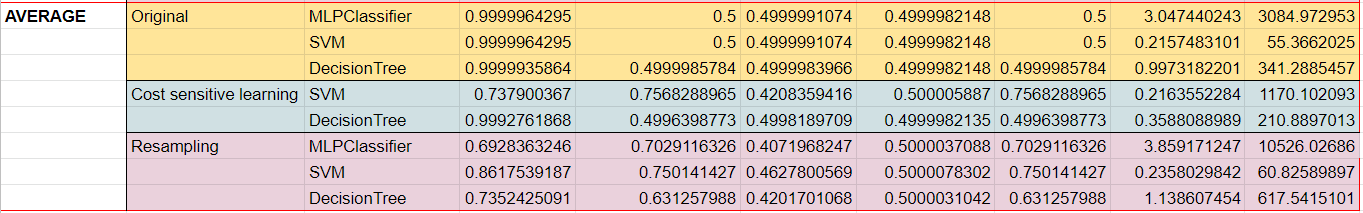

In [ ]:
%%writefile scores.csv
0.99999643,0.5,0.499999107,0.499998215,0.5,3.047440243,3084.972953
0.99999643,0.5,0.499999107,0.499998215,0.5,0.21574831,55.3662025
0.999993586,0.499998578,0.499998397,0.499998215,0.499998578,0.99731822,341.2885457
0.737900367,0.756828897,0.420835942,0.500005887,0.756828897,0.216355228,1170.102093
0.999276187,0.499639877,0.499818971,0.499998214,0.499639877,0.358808899,210.8897013
0.692836325,0.702911633,0.407196825,0.500003709,0.702911633,3.859171247,10526.02686
0.861753919,0.750141427,0.462780057,0.50000783,0.750141427,0.235802984,60.82589897
0.735242509,0.631257988,0.420170107,0.500003104,0.631257988,1.138607454,617.5415101

Overwriting scores.csv


In [ ]:
models = ['MLPClassifier_original','SGDClassifier_original','DecisionTreeClassifier_original','SGDClassifier_cost_sensitive_learning',
          'DecisionTreeClassifier_cost_sensitive_learning','MLPClassifier_resampling','SGDClassifier_resampling','DecisionTreeClassifier_resampling']
scores = pd.read_csv('scores.csv', header=None)
scores.index = models
scores.columns=['acc','balanced_acc',	'f1_score',	'precision_score',	'recall_score',	'min/time_to_predict',	'min/time_to_train']
scores

,acc,balanced_acc,f1_score,precision_score,recall_score,min/time_to_predict,min/time_to_train
MLPClassifier_original,0.999996,0.500000,0.499999,0.499998,0.500000,3.047440,3084.972953
SGDClassifier_original,0.999996,0.500000,0.499999,0.499998,0.500000,0.215748,55.366202
DecisionTreeClassifier_original,0.999994,0.499999,0.499998,0.499998,0.499999,0.997318,341.288546
SGDClassifier_cost_sensitive_learning,0.737900,0.756829,0.420836,0.500006,0.756829,0.216355,1170.102093
DecisionTreeClassifier_cost_sensitive_learning,0.999276,0.499640,0.499819,0.499998,0.499640,0.358809,210.889701
MLPClassifier_resampling,0.692836,0.702912,0.407197,0.500004,0.702912,3.859171,10526.026860
SGDClassifier_resampling,0.861754,0.750141,0.462780,0.500008,0.750141,0.235803,60.825899
DecisionTreeClassifier_resampling,0.735243,0.631258,0.420170,0.500003,0.631258,1.138607,617.541510


In [ ]:
scaled_scores = scores.copy()
scaled_scores['min/time_to_train'] =1/(scaled_scores['min/time_to_train']/min(scaled_scores['min/time_to_train']))
scaled_scores['min/time_to_predict'] =1/(scaled_scores['min/time_to_predict']/min(scaled_scores['min/time_to_predict']))

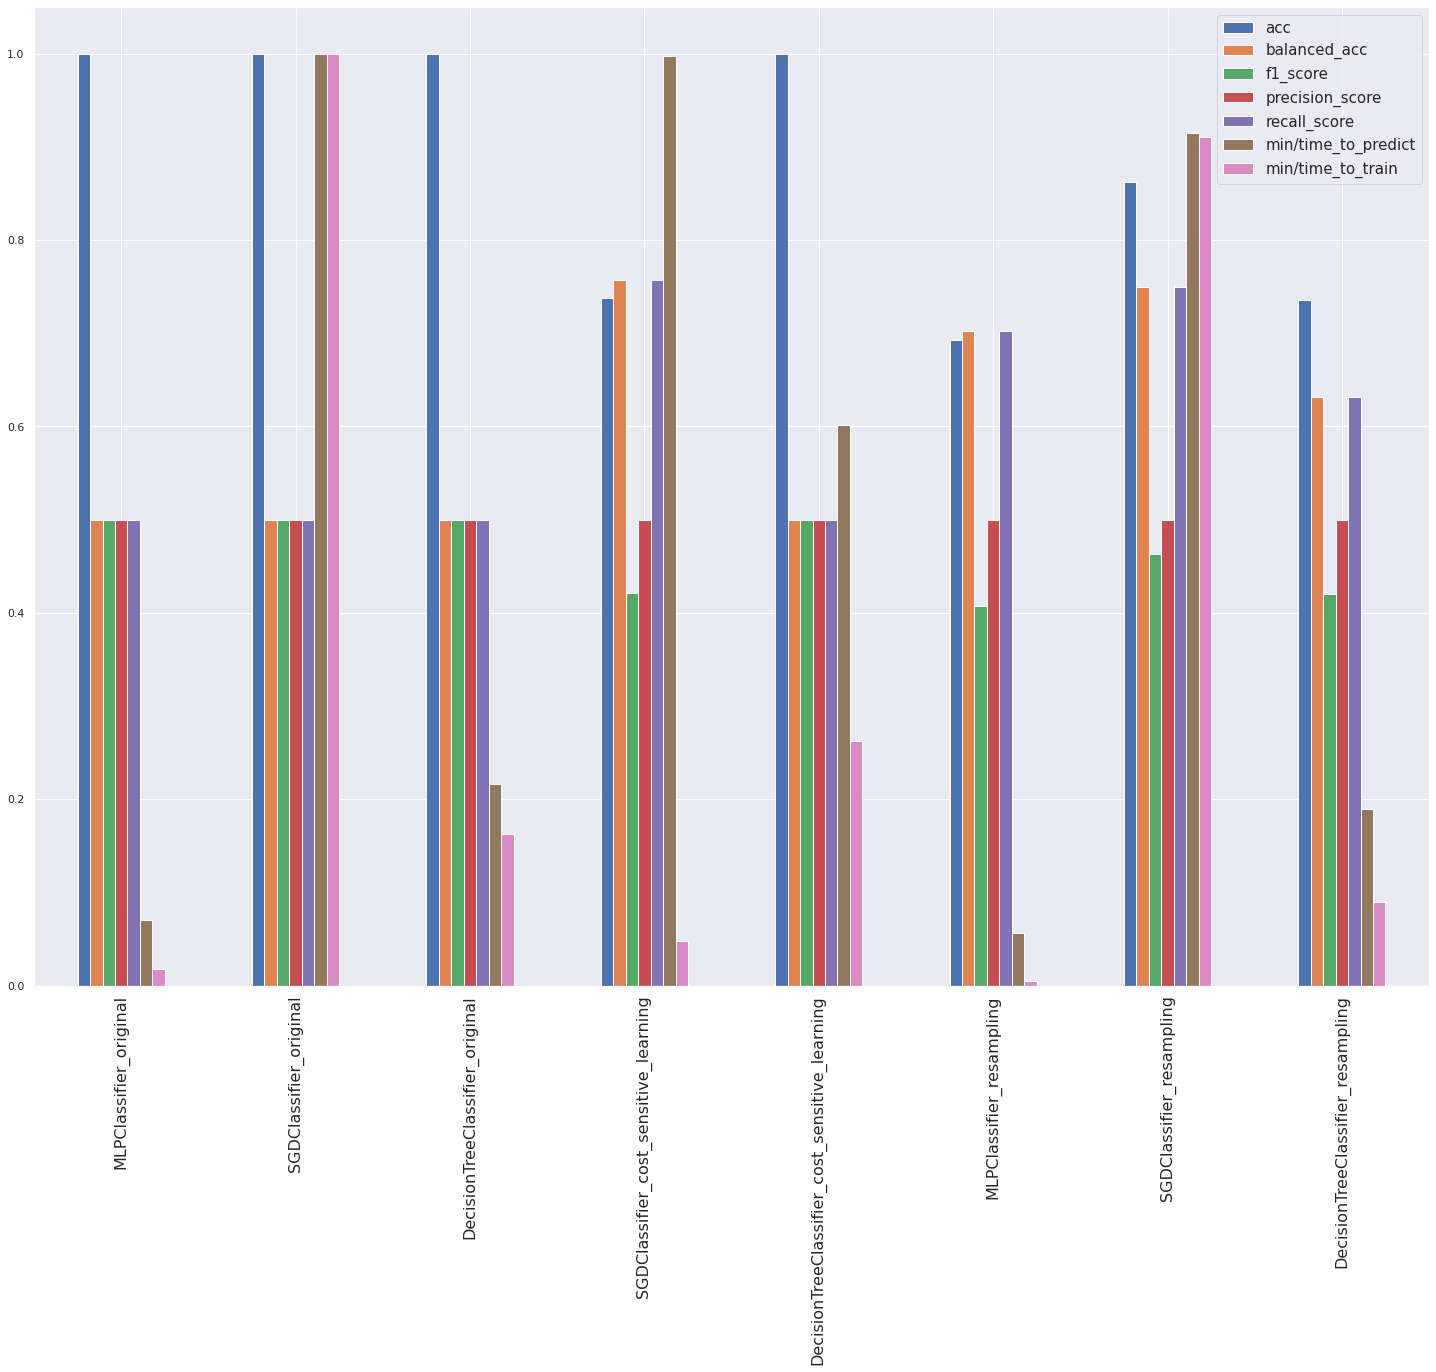

In [ ]:
sns.set(font_scale=1)
ax = scaled_scores.plot.bar(figsize=(25,18))
plt.xticks(rotation=90, fontsize=16)
plt.legend(prop={'size': 15})
ax.figure.savefig('compare_models.png')